**Import necessary libraries**

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tensorflow import keras
import re
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/meytiii/Deep-Learning/main/datasets/shahname.csv -O shahname.csv

--2024-06-26 20:08:59--  https://raw.githubusercontent.com/meytiii/Deep-Learning/main/datasets/shahname.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5609688 (5.3M) [text/plain]
Saving to: ‘shahname.csv’

shahname.csv        100%[===================>]   5.35M  --.-KB/s    in 0.07s   

2024-06-26 20:08:59 (78.5 MB/s) - ‘shahname.csv’ saved [5609688/5609688]



In [3]:
df = pd.read_csv('shahname.csv')
text = '\n'.join(df['Text'])
# Display the first 250 characters of the text
print(text[:250])

به نام خداوند جان و خرد
کز این برتر اندیشه بر نگذرد
خداوند نام و خداوند جای
خداوند روزی ده رهنمای
خداوند کیوان و گَردان سپهر
فروزندهٔ ماه و ناهید و مهر
ز نام و نشان و گمان برتر است
نگارندهٔ بر شده پیکر است
به بینندگان آفریننده را
نبینی مرنجان دو بینن


**Preprocess the text: tokenization into words**

In [4]:
text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
words = text.split(' ')
print(f'Total words: {len(words)}')


Total words: 567173


**Create a vocabulary of unique words**

In [5]:
vocab = sorted(set(words))
print(f'{len(vocab)} unique words')
for v in vocab[:100]:  # Display the first 100 words
    print(f'{v}', end=' ')

# Mapping from words to IDs and vice versa
ids_to_words = keras.layers.StringLookup(vocabulary=vocab, invert=True, mask_token=None)
ids_from_words = keras.layers.StringLookup(vocabulary=vocab, invert=False, mask_token=None)

19354 unique words
(؟) (را) (و) «بدان «بی‌آنکش «خداوند «ره «و» ، ؟ آئین آب آب، آباد آبادبوم آبادتر آبادجای آبادشهر آبادگان آبار آبت آبتین آبتینش آبخور آبداده آبدار آبداری آبدستان آبدن آبروی آبست آبستن آبستنست آبستنی آبش آبشخور آبشخورت آبشخورست آبشخورش آبشخورم آبنوس آبنوسی آبه آبها آبهای آبِ آبْ آبچین آبکش آبگون آبگیر آبگیرست آبگیرش آبگیری آبگینه آبی آب‌روی آب‌ها آب‌کش آب‌گون آب‌گیر آب‌یابی آتش آتشت آتشست آتشستی آتشش آتشکدست آتشکده آتشی آتش‌آمیز آتش‌پرست آتش‌پرستان آثار آخت آختم آختن آختند آخته آختی آخر آخری آخور آخُر آدم آدمی آدمیست آدینه آذر آذرآبادگان آذرا آذرابادگان آذران آذراندر آذرش آذرمهان آذرنگ آذرپرست آذرپناه آذرگشسب 

In [6]:
for v in ids_from_words.get_vocabulary()[:100]:  # Display the first 100 words
    print(v, end=' ')

[UNK] (؟) (را) (و) «بدان «بی‌آنکش «خداوند «ره «و» ، ؟ آئین آب آب، آباد آبادبوم آبادتر آبادجای آبادشهر آبادگان آبار آبت آبتین آبتینش آبخور آبداده آبدار آبداری آبدستان آبدن آبروی آبست آبستن آبستنست آبستنی آبش آبشخور آبشخورت آبشخورست آبشخورش آبشخورم آبنوس آبنوسی آبه آبها آبهای آبِ آبْ آبچین آبکش آبگون آبگیر آبگیرست آبگیرش آبگیری آبگینه آبی آب‌روی آب‌ها آب‌کش آب‌گون آب‌گیر آب‌یابی آتش آتشت آتشست آتشستی آتشش آتشکدست آتشکده آتشی آتش‌آمیز آتش‌پرست آتش‌پرستان آثار آخت آختم آختن آختند آخته آختی آخر آخری آخور آخُر آدم آدمی آدمیست آدینه آذر آذرآبادگان آذرا آذرابادگان آذران آذراندر آذرش آذرمهان آذرنگ آذرپرست آذرپناه 

**Convert text to sequence of IDs**

In [7]:
all_ids = ids_from_words(tf.strings.split(text))
all_ids = tf.squeeze(all_ids)  # Ensure the shape is correct
print(all_ids[:20])  # Display the first 20 IDs

tf.Tensor(
[ 4398 13240  6942  6452 15191  6989 17795  1422  2996  1201  2727 14320
  6942 13240 15191  6942  6477  6942  9128  8192], shape=(20,), dtype=int64)


**Define sequence length and batch size**

In [8]:
SEQUENCE_LENGTH = 20  # Since we are working at the word level, we can use a smaller sequence length
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

**Create a dataset of sequences**

In [9]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = ids_dataset.batch(SEQUENCE_LENGTH + 1, drop_remainder=True, num_parallel_calls=AUTOTUNE)

**Split input and target texts**

In [10]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target, num_parallel_calls=AUTOTUNE)

# Create training batches
dataset = dataset.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
dataset = dataset.prefetch(AUTOTUNE)

**Creating and compiling our model**

In [11]:
# Model parameters
VOCAB_SIZE = len(ids_from_words.get_vocabulary())
EMBEDDING_DIM = 256
RNN_UNITS = 1024

# Define the model
class MyModel(keras.Model):
    def __init__(self, vocabulary_size, embedding_dim, rnn_units):
        super(MyModel, self).__init__()
        self.embedding = keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)
        self.gru = keras.layers.GRU(units=rnn_units, return_sequences=True, return_state=True)
        self.dense = keras.layers.Dense(vocabulary_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = self.embedding(inputs, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        if return_state:
            return x, states
        return x

model = MyModel(vocabulary_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS)

# Compile the model
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Set up checkpoints
checkpoints_dir = './temp/chpts/'
checkpoint_prefix = os.path.join(checkpoints_dir, 'chpt_{epoch}')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

# Train the model
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
422/422 [==============================] - 51s 94ms/step - loss: 7.2089
Epoch 2/30
422/422 [==============================] - 28s 65ms/step - loss: 6.2991
Epoch 3/30
422/422 [==============================] - 31s 73ms/step - loss: 5.7469
Epoch 4/30
422/422 [==============================] - 29s 69ms/step - loss: 5.2930
Epoch 5/30
422/422 [==============================] - 28s 67ms/step - loss: 4.8939
Epoch 6/30
422/422 [==============================] - 28s 66ms/step - loss: 4.5165
Epoch 7/30
422/422 [==============================] - 28s 67ms/step - loss: 4.1696
Epoch 8/30
422/422 [==============================] - 28s 68ms/step - loss: 3.8535
Epoch 9/30
422/422 [==============================] - 30s 71ms/step - loss: 3.5657
Epoch 10/30
422/422 [==============================] - 30s 71ms/step - loss: 3.3090
Epoch 11/30
422/422 [==============================] - 28s 67ms/step - loss: 3.0771
Epoch 12/30
422/422 [==============================] - 28s 67ms/step - loss: 2.8666
E

**Plot the training loss**

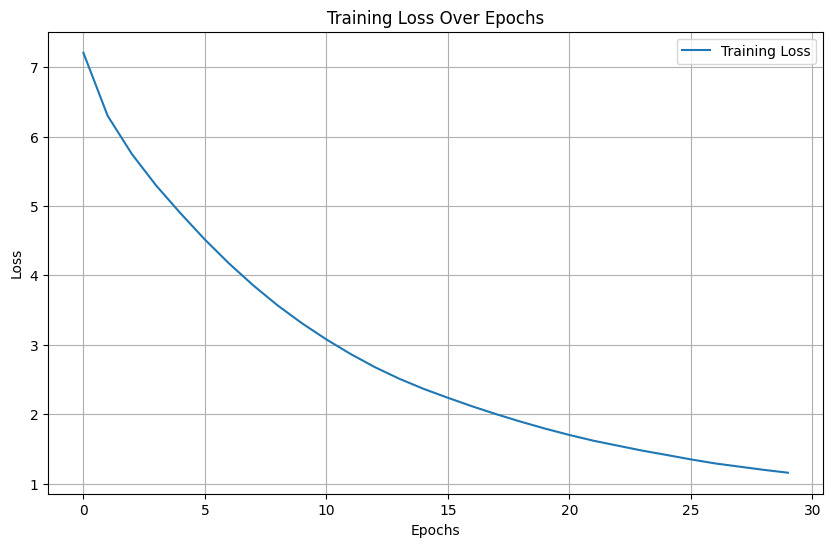

In [12]:
def plot_training_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_loss(history)

**Define a class for generating text**

In [14]:
class OneStep(tf.keras.Model):
    def __init__(self, model, ids_to_words, ids_from_words, temperature=1.0):
        super(OneStep, self).__init__()
        self.temperature = temperature
        self.model = model
        self.ids_to_words = ids_to_words
        self.ids_from_words = ids_from_words
        self.vocab_size = ids_from_words.vocabulary_size()

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Expand dims to match the expected shape: (batch_size, sequence_length)
        inputs = tf.expand_dims(inputs, 0)  # from (sequence_length,) to (1, sequence_length)

        predicted_logits, states = self.model(inputs, states=states, return_state=True)
        predicted_logits = predicted_logits[:, -1, :]  # get the last time step's output
        predicted_logits = predicted_logits / self.temperature

        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        predicted_words = self.ids_to_words(predicted_ids)
        return predicted_words, states

**Plot sample generated text**

In [15]:
def plot_generated_text(seed_text, one_step_model, num_generate=100):
    seed_ids = ids_from_words(tf.strings.split(seed_text))
    generated_poem = seed_text + '\n'
    states = None
    next_input = seed_ids
    word_count = 0
    line_length = 5
    num_lines = 5
    num_stanzas = 4

    for _ in range(num_generate):
        next_word, states = one_step_model.generate_one_step(next_input, states=states)
        next_word = next_word.numpy()[0].decode('utf-8')
        generated_poem += ' ' + next_word
        word_count += 1

        if word_count % line_length == 0:
            generated_poem += '\n'

        if word_count % (line_length * num_lines) == 0:
            generated_poem += '\n'

        next_input = tf.expand_dims(ids_from_words(tf.constant(next_word)), 0)

    print(generated_poem)

# Generate and plot text
one_step_model = OneStep(model, ids_to_words, ids_from_words, temperature=1.2)
seed_text = "به نام خداوند جان و خرد"
plot_generated_text(seed_text, one_step_model)

به نام خداوند جان و خرد
 که این روشن گیتی به
 سوگند پیمان بود جهان به
 ایوان بدانگه بران تاج بر
 تخت نیز به درگاه کرد
 آن جهاندار شاه بدان جشن

 و این جشن و آن
 کار باز ز کار جهان
 بخت گردد دراز به ژرفی
 چنین داد تا تخت من
 شدی خسرو برآمد ز ایران

 خروش که ای ای سپاس
 تو این پیر شاه سزد
 گر بر تخت فرخنده باد
 تو این و خرد نیست
 با شاه پیش سپه من

 به آیین و راه دراز
 چو در جنگ لشکر به
 خسرو سپرد دگر آنک گفتی
 که چشم نباشد خرد را
 دلش ننگ و ایرانیان را




**Generating text and testing our model**

In [16]:
# Define a class for generating text
class OneStep(tf.keras.Model):
    def __init__(self, model, ids_to_words, ids_from_words, temperature=1.0):
        super(OneStep, self).__init__()
        self.temperature = temperature
        self.model = model
        self.ids_to_words = ids_to_words
        self.ids_from_words = ids_from_words
        self.vocab_size = ids_from_words.vocabulary_size()

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Expand dims to match the expected shape: (batch_size, sequence_length)
        inputs = tf.expand_dims(inputs, 0)  # from (sequence_length,) to (1, sequence_length)

        predicted_logits, states = self.model(inputs, states=states, return_state=True)
        predicted_logits = predicted_logits[:, -1, :]  # get the last time step's output
        predicted_logits = predicted_logits / self.temperature

        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        predicted_words = self.ids_to_words(predicted_ids)
        return predicted_words, states

# Generate text
one_step_model = OneStep(model, ids_to_words, ids_from_words, temperature=1.2)  # Adjust temperature

# Start seed text
seed_text = "به نام خداوند جان و خرد"
seed_ids = ids_from_words(tf.strings.split(seed_text))

# Number of words to generate
num_generate = 100

# Poem structure parameters
line_length = 5  # Number of words per line
num_lines = 5    # Number of lines per stanza
num_stanzas = 4  # Number of stanzas

# Generate the poem
generated_poem = seed_text
generated_poem += '\n'  # Start a new line after the seed text

states = None
next_input = seed_ids
word_count = 0

for _ in range(num_generate):
    next_word, states = one_step_model.generate_one_step(next_input, states=states)
    next_word = next_word.numpy()[0].decode('utf-8')  # Convert to string
    generated_poem += ' ' + next_word
    word_count += 1

    # Insert a line break after every `line_length` words
    if word_count % line_length == 0:
        generated_poem += '\n'

    # Insert a stanza break after every `num_lines` lines
    if word_count % (line_length * num_lines) == 0:
        generated_poem += '\n'

    next_input = tf.expand_dims(ids_from_words(tf.constant(next_word)), 0)

print(generated_poem)

به نام خداوند جان و خرد
 آتش بران خویش بر وی
 بگشت جهانی بران آرزو بر
 پدر فرستاد موبد به ایوان
 خویش که دارد به گیتی
 ورا خویش و خط نگه

 کن بدین با شما که
 نیرو بود زین جهان خویش
 بر زین کزو بد مکن
 بر تو پاداش بد بدو
 گفت خوانی که فرزند خویش

 به بر زین نپیچد ورا
 باد پای که بر زین
 به ایران و نیران منم
 ز زین تا شود زان
 پس که ای شه به

 رنج تو بر تخت بر
 تخت زرین نهاد به دل
 بر سر انجمن آوری نیست
 اگر مرگ بد برو بر
 به تخت برادر به رنج


